In [565]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

Suppose you are a Data Scientist on the Mobile team at Quora.<br>
The team has just introduced a new UI design to the Quora app.<br>
The goal of the new design is to increase user engagement (measured by minutes spent on site).<br>
The team ran an A/B test to evaluate the change.<br>
Using the data, help the team understand the impact of the UI change better.<br>

Tables provided are as follows:

1. t1_user_active_min.csv
2. t2_user_variant.csv
3. t3_user_active_min_pre.csv
4. t4_user_attributes.csv

In [2]:
# reading the data sets
t1_user_active_min     = pd.read_csv("t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("t4_user_attributes.csv")
df_list                = [t1_user_active_min,t2_user_variant,t3_user_active_min_pre,t4_user_attributes]

In [3]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [638]:
t1_user_active_min.shape

(1066402, 3)

In [583]:
# Outlier Greater than 24*60 mins in a day.
t1_user_active_min.active_mins[(t1_user_active_min.active_mins > 24*60) & 
                               (t1_user_active_min.active_mins < t1_user_active_min.active_mins.max())]

Series([], Name: active_mins, dtype: float64)

In [4]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [5]:
t2_user_variant['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

80 percent users in control group.<br>
20 percent users in treatment group.

In [6]:
#user_control   = t2_user_variant.loc[t2_user_variant['variant_number'] == 0, 'uid'].to_list()
#user_treatment = t2_user_variant.loc[t2_user_variant['variant_number'] == 1, 'uid'].to_list()

In [7]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [8]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


## Hypothesis:
The AB Testing is intended to increase the user engagement in terms of time.<br>
Randomized people are used to divide into control and treatment groups.<br>
## Metrics for A/B Test to look for between treatment and control groups:
Active time - increased/decreased<br>
Frequency of visit - increased/decreased<br>
Segregation of above two points for old/new users, male/female, reader/non-readers.<br>
I will try to look for the combination of all the other factors<br>

<b>Creating Data Table for the user attributes and variants - combination of gender/reader/non-reader/days_since_signup</b>

In [9]:
t5_user_var_attr = pd.merge(t2_user_variant, t4_user_attributes,how = "inner", on = "uid")

In [10]:
t5_user_var_attr.head()

,uid,variant_number,dt,signup_date,gender,user_type
0,0,0,2019-02-06,2018-09-24,male,non_reader
1,1,0,2019-02-06,2016-11-07,male,reader
2,2,0,2019-02-06,2018-09-17,male,non_reader
3,3,0,2019-02-06,2018-03-04,male,non_reader
4,4,0,2019-02-06,2017-03-09,male,non_reader


In [11]:
t5_user_var_attr_control = t5_user_var_attr[t5_user_var_attr['variant_number'] == 0]
t5_user_var_attr_treatment = t5_user_var_attr[t5_user_var_attr['variant_number'] == 1]
#cat_cols = ['gender','user_type']
#cont_cols = ['days_since_joined_till_AB_tested']

<b>Checking the ratio in treatment and control group</b>

In [50]:
groups = ['control', 'treat', 'total']
variants = ['gender', 'user_type']

dict_data = {'control':t5_user_var_attr_control,
             'treat':t5_user_var_attr_treatment,
             'total':t5_user_var_attr}

dict_counts = {}

for v in variants:
    dict_counts[v] = {}
    
    for g in groups:
        dict_counts[v][g] = dict_data[g][[v, 'uid']] \
        .groupby([v])[['uid']].count() \
        .rename(columns = {'uid':g + '_count'}) \
        .reset_index()
    
    dict_counts[v]['compare'] = pd.merge(dict_counts[v]['control'], 
                                         dict_counts[v]['treat'], on = v, how = "inner")
    for g in groups[:-1]:
        dict_counts[v]['compare'][g + '_ratio'] = \
        dict_counts[v]['compare'][g + '_count'] / dict_counts[v]['compare'][g + '_count'].sum()

In [53]:
dict_counts['gender']['compare'].drop(columns = ['control_count','treat_count'])

,gender,control_ratio,treat_ratio
0,female,0.290175,0.287
1,male,0.555925,0.552
2,unknown,0.153900,0.161


In [54]:
dict_counts['gender']['compare'].drop(columns = ['control_count','treat_count'])

,gender,control_ratio,treat_ratio
0,female,0.290175,0.287
1,male,0.555925,0.552
2,unknown,0.153900,0.161


### After the test is conducted

# Alternatives: Store dataframes in dictionaries

In [ ]:
def intersect(list1, list2): 
    return list(set(list1) & set(list2))

In [95]:
uid_control = list(t5_user_var_attr_control["uid"])
uid_treat   = list(t5_user_var_attr_treatment["uid"])

In [96]:
# Check if there are common uid between control and treatment?
intersect(uid_control, uid_treat)

[]

In [544]:
groups = ['control', 'treat']
periods = ['pre', 'post']

uid = {'control':uid_control, 'treat':uid_treat}

dict_data = {'pre':t3_user_active_min_pre,
             'post':t1_user_active_min}

dict_uid = {}

# Extract uid of pre and post per group
for p in periods:
    dict_uid[p] = {}
    
    for g in groups:
        dict_uid[p][g] = set(dict_data[p].loc[dict_data[p]['uid'].isin(uid[g]), 'uid'])

# Create intersection of pre and post uid per group
dict_uid['common'] = {}

for g in groups:
    dict_uid['common'][g] = intersect(dict_uid['pre'][g], dict_uid['post'][g])

# Store active mins, and merged vairants and attributes dataframes
dict_mins = {}
dict_tables = {}

for p in periods:
    dict_mins[p] = {}
    dict_tables[p] = {}
    
    for g in groups:
        dict_mins[p][g] = dict_data[p][dict_data[p]['uid'].isin(dict_uid['common'][g])]
        dict_tables[p][g] = pd.merge(dict_mins[p][g], t5_user_var_attr, how = "inner", on = "uid") \
        .rename(columns = {"dt_x":"date","dt_y":"AB_date"})

In [124]:
dict_mins['pre']['control'].head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [126]:
dict_tables['pre']['control'].head()

,uid,date,active_mins,variant_number,AB_date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


In [136]:
dict_tables['post']['control'].head()

,uid,date,active_mins,variant_number,AB_date,signup_date,gender,user_type
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24,male,non_reader


## Compare active minutes summary

In [170]:
for p in periods:
    for g in groups:
        print(p.title() + '-test ' + g.title() + 
              ' Summary\n' + str(pd.DataFrame(dict_tables[p][g]['active_mins'].describe())) + 
              '\n')

Pre-test Control Summary
        active_mins
count  978727.00000
mean       35.77256
std      1283.01916
min         1.00000
25%         2.00000
50%         5.00000
75%        15.00000
max     99999.00000

Pre-test Treat Summary
         active_mins
count  197942.000000
mean       16.222444
std       503.548367
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max     99999.000000

Post-test Control Summary
         active_mins
count  886469.000000
mean       35.361478
std      1266.081303
min         1.000000
25%         2.000000
50%         5.000000
75%        16.000000
max     99999.000000

Post-test Treat Summary
         active_mins
count  179291.000000
mean       40.270471
std      1294.258138
min         1.000000
25%         3.000000
50%         7.000000
75%        19.000000
max     99999.000000



In [545]:
dict_tables['post']['treat'].sort_values(by=['active_mins']).tail()

,uid,date,active_mins,variant_number,AB_date,signup_date,gender,user_type
61909,43503,2019-03-05,99999.0,1,2019-02-06,2018-10-03,female,contributor
45007,42544,2019-06-16,99999.0,1,2019-02-06,2018-11-05,unknown,contributor
80080,44512,2019-04-01,99999.0,1,2019-02-06,2016-11-01,male,reader
170006,49503,2019-02-10,99999.0,1,2019-02-06,2017-05-26,male,contributor
145663,48148,2019-02-20,99999.0,1,2019-02-06,2017-09-21,male,reader


In [546]:
dict_tables_cut = {}
for p in periods:
    dict_tables_cut[p] = {}
    
    for g in groups:
        dict_tables_cut[p][g] = dict_tables[p][g][dict_tables[p][g]['active_mins']
                                                  < dict_tables[p][g]['active_mins'].quantile(0.92)]

In [547]:
dict_tables_cut['post']['control'].sort_values(by=['active_mins']).tail()

,uid,date,active_mins,variant_number,AB_date,signup_date,gender,user_type
369465,16616,2019-06-15,59.0,0,2019-02-06,2018-10-30,male,reader
796620,36085,2019-04-14,59.0,0,2019-02-06,2015-07-20,female,reader
538294,24205,2019-04-25,59.0,0,2019-02-06,2019-02-02,unknown,new_user
122319,5509,2019-06-16,59.0,0,2019-02-06,2018-12-04,male,reader
876649,39586,2019-02-15,59.0,0,2019-02-06,2016-09-29,male,reader


# Treatment Distribution of Active Miniutes

In [261]:
def build_dist(df1, df2, col1, col2, xlabel, legend1, legend2, title):
    sns.distplot(df1[col1], hist=False, label = legend1, axlabel = xlabel)
    sns.distplot(df2[col2], hist=False, label = legend2, axlabel = xlabel)
    plt.title(title)
    plt.show()

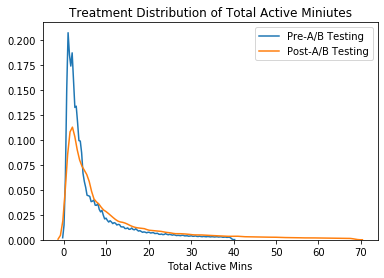

In [263]:
build_dist(dict_tables_cut['pre']['treat'], dict_tables_cut['post']['treat'],
           "active_mins","active_mins","Total Active Mins", "Pre-A/B Testing","Post-A/B Testing",
           title='Treatment Distribution of Total Active Miniutes')

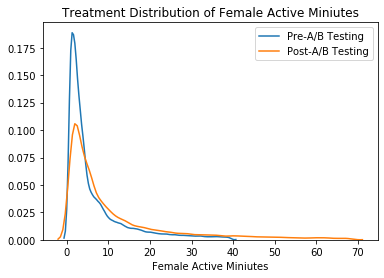

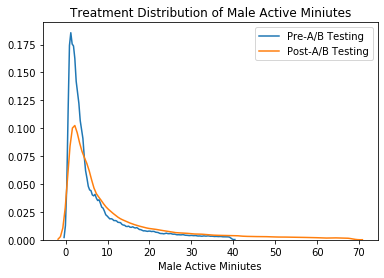

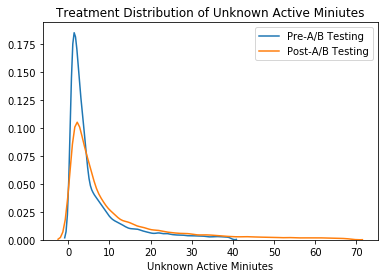

In [280]:
for gen in set(t4_user_attributes['gender']):
    build_dist(dict_tables_cut['pre']['treat'][(dict_tables_cut['pre']['treat']["gender"] == gen)],
               dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["gender"] == gen)],
               "active_mins", "active_mins", gen.title() + " Active Miniutes", "Pre-A/B Testing", "Post-A/B Testing",
               title='Treatment Distribution of ' + gen.title() + ' Active Miniutes')

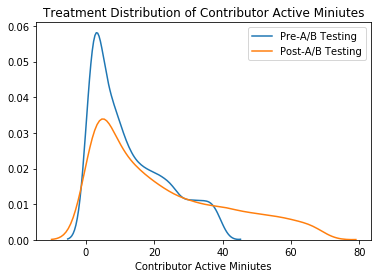

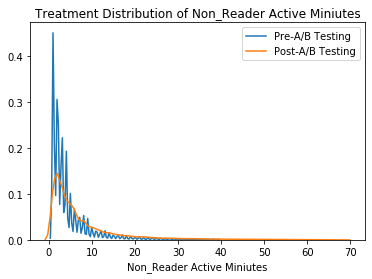

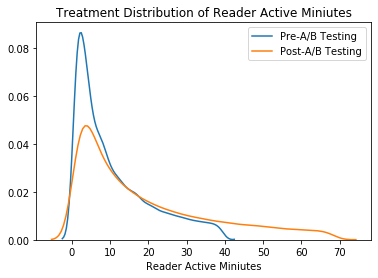

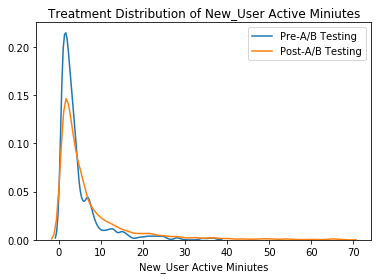

In [281]:
for typ in set(t4_user_attributes['user_type']):
    build_dist(dict_tables_cut['pre']['treat'][(dict_tables_cut['pre']['treat']["user_type"] == typ)],
               dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["user_type"] == typ)],
               "active_mins", "active_mins", typ.title() + " Active Miniutes", 
               "Pre-A/B Testing", "Post-A/B Testing",
               title='Treatment Distribution of ' + typ.title() + ' Active Miniutes')

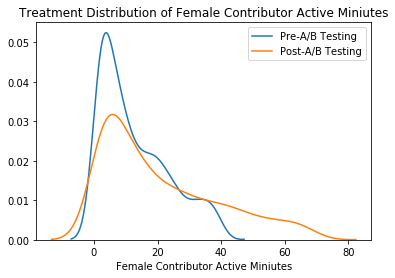

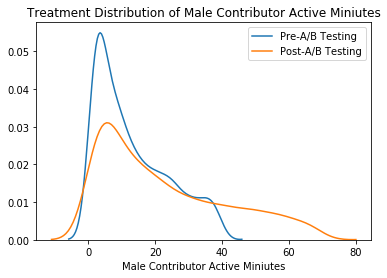

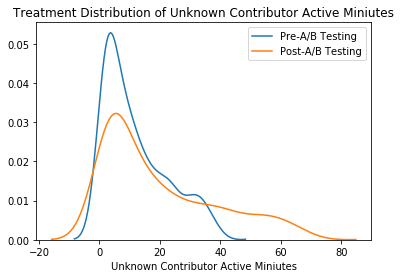

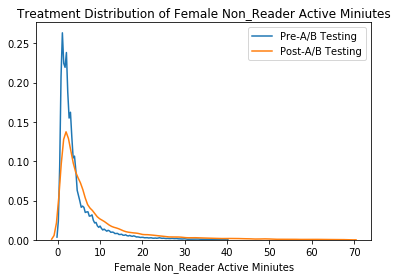

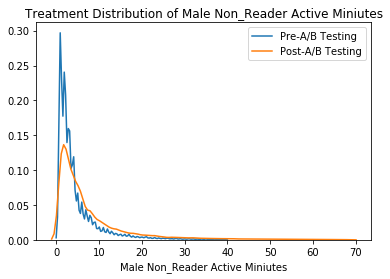

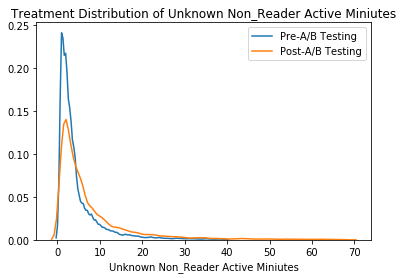

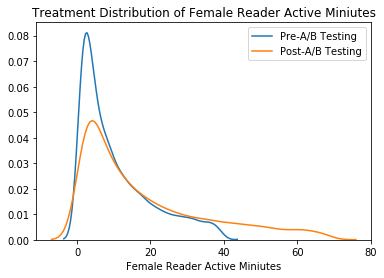

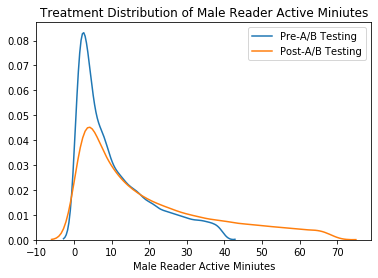

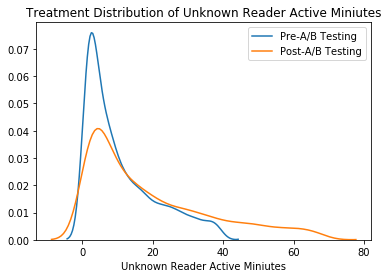

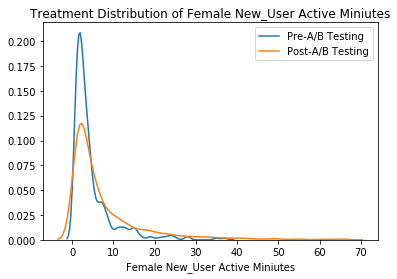

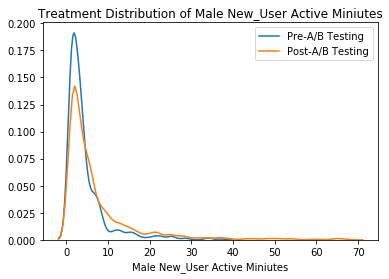

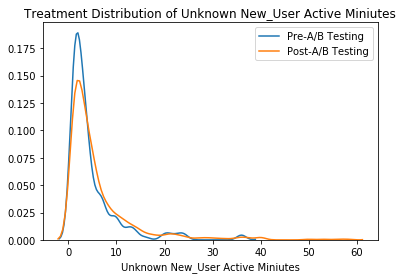

In [279]:
for typ in set(t4_user_attributes['user_type']):
    for gen in set(t4_user_attributes['gender']):
        build_dist(dict_tables_cut['pre']['treat'][(dict_tables_cut['pre']['treat']["gender"] == gen) & 
                                           (dict_tables_cut['pre']['treat']["user_type"] == typ)],
                   dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["gender"] == gen) &
                                            (dict_tables_cut['post']['treat']["user_type"] == typ)],
                   "active_mins", "active_mins", gen.title() + ' ' + typ.title() + " Active Miniutes", 
                   "Pre-A/B Testing", "Post-A/B Testing",
                   title='Treatment Distribution of ' + gen.title() + ' ' + typ.title() + ' Active Miniutes')

# Check the change in number of visits

In [307]:
# Pre and post test visit frequencies
dict_user_count = {}

for p in periods:
    dict_user_count[p] = dict_tables_cut[p]['treat'][['uid']] \
    .groupby(['uid'])[['uid']].count() \
    .rename(columns = {'uid':p + '_count'}) \
    .reset_index()

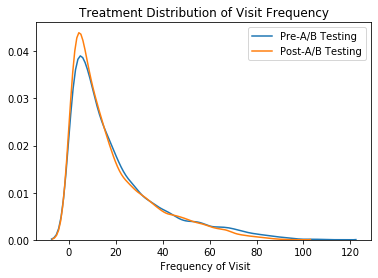

In [312]:
build_dist(dict_user_count['pre'],
           dict_user_count['post'],
           'pre_count', 'post_count',' Frequency of Visit', "Pre-A/B Testing", "Post-A/B Testing",
           title='Treatment Distribution of Visit Frequency')

In [361]:
# Pre and post test visit frequencies
frequency_effect = pd.merge(dict_user_count['pre'], dict_user_count['post'], how = "inner", on = "uid")
frequency_effect = pd.merge(frequency_effect, 
                            dict_tables_cut['post']['treat'][['uid','gender','user_type']].drop_duplicates(),
                            how = "inner", on = "uid")

In [393]:
# Which uid has frequency gone up or down?
attr_visit         = {}
attr_visit['up']   = frequency_effect.loc[frequency_effect['post_count'] \
                                                 > frequency_effect['pre_count'], ['uid','gender','user_type']]
attr_visit['down'] = frequency_effect.loc[frequency_effect['post_count'] \
                                                 <= frequency_effect['pre_count'], ['uid','gender','user_type']]

In [431]:
# Store up and down counts per attribute in dictionary
dict_analysis_count = {}
attributes = ['gender', 'user_type']

for attr in attributes:
    dict_analysis_count[attr] = {}
    
    for d in ['up', 'down']:
        dict_analysis_count[attr][d] = pd.DataFrame(attr_visit[d][attr] \
                                         .value_counts()).reset_index() \
                                         .rename(columns = {attr:d+'_post_test', 'index':attr})

for attr in attributes:
    dict_analysis_count[attr]['updown']={}
    dict_analysis_count[attr]['updown'] = pd.merge(dict_analysis_count[attr]['up'], dict_analysis_count[attr]['down'],
                                             how = 'inner', on = attr)

In [432]:
dict_analysis_count['gender']['updown'].head()

,gender,up_post_test,down_post_test
0,male,1995,3127
1,female,1044,1545
2,unknown,565,883


In [433]:
dict_analysis_count['user_type']['updown'].head()

,user_type,up_post_test,down_post_test
0,non_reader,2554,4451
1,new_user,546,223
2,reader,455,804
3,contributor,49,77


# Check the change in amount of time spent

In [447]:
# Pre and post test time spent
dict_time_spent = {}

for p in periods:
    dict_time_spent[p] = dict_tables_cut[p]['treat'] \
    .groupby(['uid'])[['active_mins']].sum() \
    .reset_index() \
    .rename(columns = {'active_mins':'time_' + p + '_test'})

In [448]:
time_spent = pd.merge(dict_time_spent['pre'], dict_time_spent['post'], on='uid', how='inner')
time_spent = pd.merge(time_spent, t4_user_attributes, on='uid', how='left')

In [450]:
# Which uid has time gone up or down?
attr_visit         = {}
attr_visit['up']   = frequency_effect.loc[time_spent['time_post_test'] \
                                          > time_spent['time_pre_test'], ['uid','gender','user_type']]
attr_visit['down'] = frequency_effect.loc[time_spent['time_post_test'] \
                                         <= time_spent['time_pre_test'], ['uid','gender','user_type']]

In [451]:
# Store up and down time per attribute in dictionary
dict_analysis_time = {}
attributes = ['gender', 'user_type']

for attr in attributes:
    dict_analysis_time[attr] = {}
    
    for d in ['up', 'down']:
        dict_analysis_time[attr][d] = pd.DataFrame(attr_visit[d][attr] \
                                         .value_counts()).reset_index() \
                                         .rename(columns = {attr:d + '_post_test', 'index':attr})

for attr in attributes:
    dict_analysis_time[attr]['updown']={}
    dict_analysis_time[attr]['updown'] = pd.merge(dict_analysis_time[attr]['up'], dict_analysis_time[attr]['down'],
                                             how = 'inner', on = attr)

In [452]:
dict_analysis_time['gender']['updown'].head()

,gender,up_post_test,down_post_test
0,male,3280,1842
1,female,1604,985
2,unknown,894,554


In [453]:
dict_analysis_time['user_type']['updown'].head()

,user_type,up_post_test,down_post_test
0,non_reader,4165,2840
1,reader,915,344
2,new_user,608,161
3,contributor,90,36


# Between post-test control and treatment group

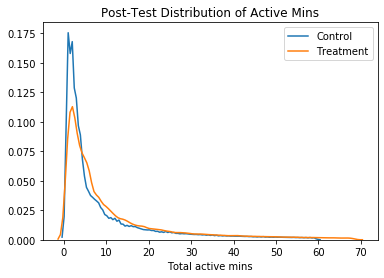

In [463]:
build_dist(dict_tables_cut['post']['control'], dict_tables_cut['post']['treat'],
           "active_mins","active_mins","Total active mins","Control","Treatment",
           title='Post-Test Distribution of Active Mins')

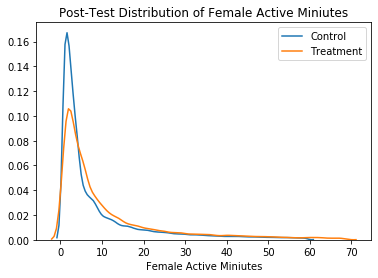

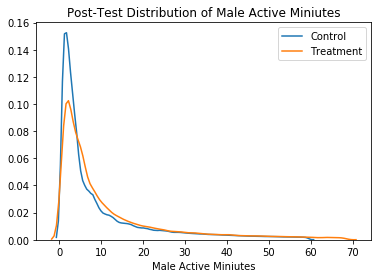

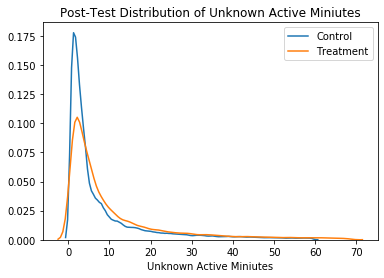

In [465]:
for gen in set(t4_user_attributes['gender']):
    build_dist(dict_tables_cut['post']['control'][(dict_tables_cut['post']['control']["gender"] == gen)],
               dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["gender"] == gen)],
               "active_mins", "active_mins", gen.title() + " Active Miniutes", "Control","Treatment",
               title='Post-Test Distribution of ' + gen.title() + ' Active Miniutes')

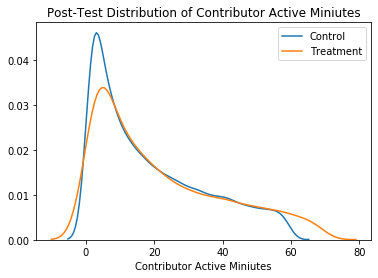

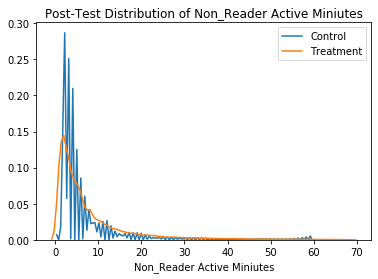

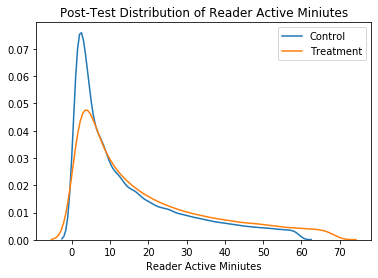

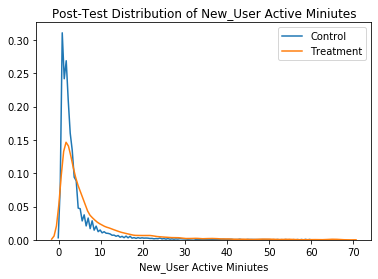

In [466]:
for typ in set(t4_user_attributes['user_type']):
    build_dist(dict_tables_cut['post']['control'][(dict_tables_cut['post']['control']["user_type"] == typ)],
               dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["user_type"] == typ)],
               "active_mins", "active_mins", typ.title() + " Active Miniutes", 
               "Control","Treatment",
               title='Post-Test Distribution of ' + typ.title() + ' Active Miniutes')

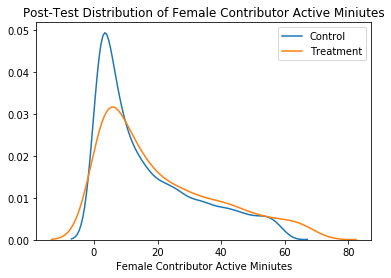

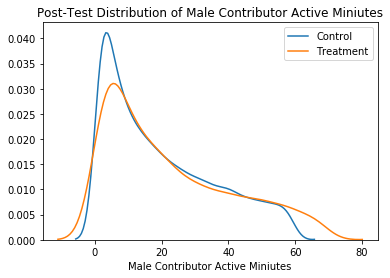

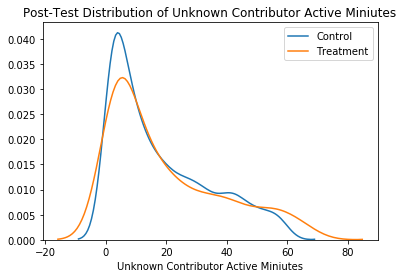

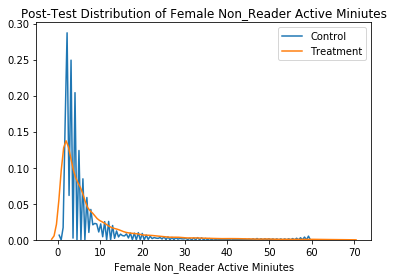

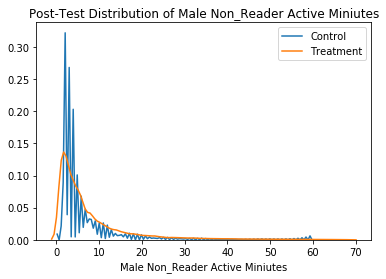

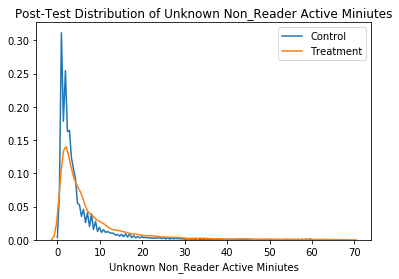

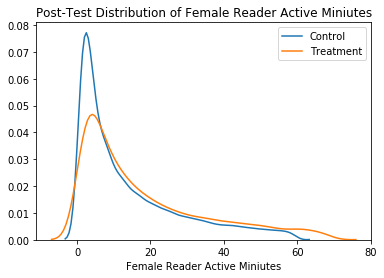

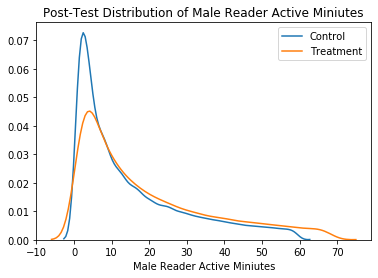

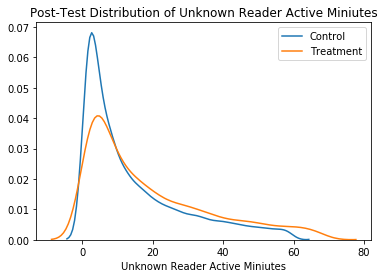

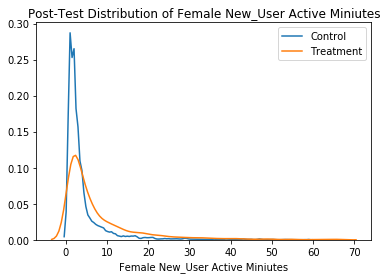

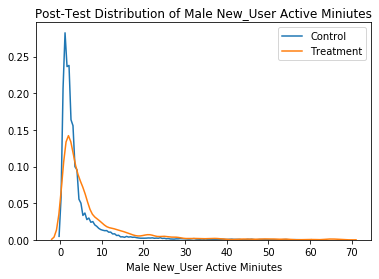

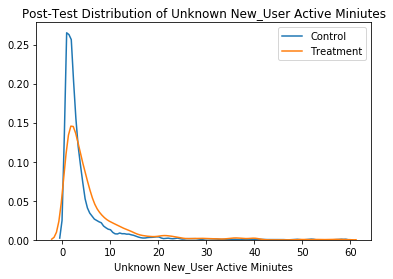

In [469]:
for typ in set(t4_user_attributes['user_type']):
    for gen in set(t4_user_attributes['gender']):
        build_dist(dict_tables_cut['post']['control'][(dict_tables_cut['post']['control']["gender"] == gen) & 
                                           (dict_tables_cut['post']['control']["user_type"] == typ)],
                   dict_tables_cut['post']['treat'][(dict_tables_cut['post']['treat']["gender"] == gen) &
                                            (dict_tables_cut['post']['treat']["user_type"] == typ)],
                   "active_mins", "active_mins", gen.title() + ' ' + typ.title() + " Active Miniutes", 
                   "Control","Treatment",
                   title='Post-Test Distribution of ' + gen.title() + ' ' + typ.title() + ' Active Miniutes')

# Regrression and p-value analysis

In [548]:
# Changing date to datetime type
for p in periods:
    for g in groups:
        for d in ['date', 'AB_date', 'signup_date']:
            dict_tables[p][g].loc[:,d] = pd.to_datetime(dict_tables[p][g][d])
            dict_tables_cut[p][g].loc[:,d] = pd.to_datetime(dict_tables_cut[p][g][d])
            
        dict_tables[p][g].loc[:,'days_since_signup'] = \
        (dict_tables[p][g]['AB_date'] - dict_tables[p][g]['signup_date']).apply(lambda x:x.days)
        dict_tables_cut[p][g].loc[:,'days_since_signup'] = \
        (dict_tables_cut[p][g]['AB_date'] - dict_tables_cut[p][g]['signup_date']).apply(lambda x:x.days)

/Users/shinggg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/shinggg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [549]:
# Create dataset for regressions
for p in periods:
    for g in groups:
        dum_1 = pd.get_dummies(dict_tables[p][g]['gender'])
        dum_2 = pd.get_dummies(dict_tables[p][g]['user_type'])
        dict_tables[p][g] = pd.concat([dict_tables[p][g],dum_1,dum_2], axis = 1)
        dict_tables[p][g].drop(columns=['date','AB_date','signup_date'], inplace=True)
        temp = dict_tables[p][g]['uid'].value_counts().reset_index().rename(columns = {'uid':'counts','index':'uid'})
        dict_tables[p][g] = pd.merge(dict_tables[p][g], temp, how = "inner", on = "uid")
        col_to_group_by = list(dict_tables[p][g].columns)
        col_to_group_by.remove('active_mins')
        dict_tables[p][g] = dict_tables[p][g].groupby(col_to_group_by)[['active_mins']].sum().reset_index().drop(columns = ['user_type','gender'])
        dict_tables[p][g]['avg_time_per_user'] = dict_tables[p][g]['active_mins'] / dict_tables[p][g]['counts']
        dict_tables[p][g].to_csv(str(p) + "_" + str(g) + "_table.csv", index = False)

In [550]:
dict_tables['post']['treat'].head()

,uid,variant_number,days_since_signup,female,male,unknown,contributor,new_user,non_reader,reader,counts,active_mins,avg_time_per_user
0,40001,1,648,0,1,0,0,0,1,0,32,299.0,9.343750
1,40002,1,1264,0,1,0,0,0,1,0,26,183.0,7.038462
2,40004,1,1396,1,0,0,0,0,1,0,9,56.0,6.222222
3,40005,1,703,1,0,0,0,0,1,0,36,289.0,8.027778
4,40006,1,964,1,0,0,0,0,1,0,36,194.0,5.388889


In [566]:
X = dict_tables['pre']['control'][dict_tables['pre']['control'].columns.difference(['active_mins'])]
y = dict_tables['pre']['control']['active_mins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
p_value_dict = dict(model.pvalues)

# Print out the statistics
model.summary()

/Users/shinggg/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/shinggg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/shinggg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/shinggg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/Users/shinggg/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            active_mins   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 1.434e+04
Date:                Sun, 22 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:32:14   Log-Likelihood:            -3.0663e+05
No. Observations:               29850   AIC:                         6.133e+05
Df Residuals:                   29840   BIC:                         6.134e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_time_per_user    80.5530      0.229    351.027      0.000      80.103      81.003
contributor        -560.7797    248.627     -2.256      0.024   -1048.099     -73.461
counts               34.1479      2.051     16.647      0.000      30.127      38.168
days_since_signup    -0.0163      0.071     -0.229      0.819      -0.156       0.123
female             -618.3256     95.560     -6.471      0.000    -805.627    -431.024
male               -728.5999     90.397     -8.060      0.000    -905.781    -551.419
new_user            212.0498    154.544      1.372      0.170     -90.862     514.962
non_reader         -278.3836     73.062     -3.810      0.000    -421.587    -135.180
reader            -1412.6891    122.837    -11.501      0.000   -1653.454   -1171.924
uid                   0.0037      0.004      1.062      0.288      -0.003       0.011
unknown            -692.8770    114.120     -6.071      0.000    -916.557    -469.197
variant_number             0          0        nan        nan           0           0
==============================================================================
Omnibus:                    81921.769   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      36251693885.029
Skew:                         -33.377   Prob(JB):                         0.00
Kurtosis:                    5401.392   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""